# Домашнее задание: аугментация датасета

Домашнее задание состоит из трех частей:
1. Загрузка и предобработка датасета. Скачать датасет можно по ссылке: https://www.kaggle.com/datasets/vencerlanz09/healthy-and-bleached-corals-image-classification Ожидаемый результат - numpy массив images с изображениями из датасета, приведенными к единому размеру: 100х100x3 с сохранением соотношения сторон.
2. Написание классов-оберток для функций преобразований, чтобы осущесвлять случайные преобразования. Ожидаемый результат - корректно работающие обертки для любых 3 цветовых преобразований, любых 5 геометических, 1 наложения шума или сглаживания на выбор.
3. Применение аугментации. Ожидаемый результат - 5 аугментированных изображений.

В конце сохраните ноутбук вместе с результатами выполнения ячеек.

## Загрузка и предобработка датасета

In [1]:
!pip install -r requirements.txt

  Using cached numpy-2.2.1-cp312-cp312-win_amd64.whl.metadata (60 kB)
Using cached numpy-2.2.1-cp312-cp312-win_amd64.whl (12.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4


  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.59.1 requires numpy<1.27,>=1.22, but you have numpy 2.2.1 which is incompatible.
pywavelets 1.5.0 requires numpy<2.0,>=1.22.4, but you have numpy 2.2.1 which is incompatible.


In [3]:
import cv2
import numpy as np
import os
import abc
import random

def load_all_jpg_images(root_dir):
    images = []
    paths = []

    for dirpath, _, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.lower().endswith('.jpg'):
                rel_path = os.path.relpath(os.path.join(dirpath, filename), root_dir)
                full_path = os.path.join(dirpath, filename)
                img = cv2.imread(full_path)

                if img is not None:
                    images.append(img)
                    paths.append(rel_path)
                else:
                    print(f"Warning: Failed to load {rel_path}")

    return images, paths

def resize(img, size=(100, 100)):
    old_h, old_w = img.shape[:2]
    new_h, new_w = size

    # Выбор интерполяции
    if old_h > new_h or old_w > new_w:
        interp = cv2.INTER_AREA  # лучше для уменьшения
    else:
        interp = cv2.INTER_CUBIC  # лучше для увеличения

    # Создаем холст из нулей (чёрный фон)
    new_img = np.zeros((new_h, new_w, img.shape[2]), dtype=img.dtype)

    ar = old_h / old_w
    if ar > 1:  # вертикальное изображение
        factor = new_h / old_h
        resize_h = new_h
        resize_w = int(old_w * factor)
    else:  # горизонтальное изображение или квадрат
        factor = new_w / old_w
        resize_w = new_w
        resize_h = int(old_h * factor)

    resized_img = cv2.resize(img, (resize_w, resize_h), interpolation=interp)

    # Вставляем центрированное изображение на холст
    start_ymin = max((new_h - resize_h) // 2, 0)
    start_xmin = max((new_w - resize_w) // 2, 0)

    new_img[start_ymin:start_ymin + resize_h, start_xmin:start_xmin + resize_w] = resized_img

    return new_img



## Написание оберток для функций преобразований

In [5]:
# В эту ячейку можно загрузить функции преобразований, написанные в практических заданиях
class ImageTransformer(abc.ABC):
    @abc.abstractmethod
    def random_transform(self, img: np.ndarray) -> np.ndarray:
        pass


class ColorTransformer(ImageTransformer):
    def random_transform(self, img: np.ndarray) -> np.ndarray:
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype(np.float32)

        # Random hue (-10 to +10), saturation (0.8–1.2), brightness (0.8–1.2)
        hue_shift = random.uniform(-10, 10)
        sat_mult = random.uniform(0.8, 1.2)
        val_mult = random.uniform(0.8, 1.2)

        hsv[..., 0] = (hsv[..., 0] + hue_shift) % 180
        hsv[..., 1] *= sat_mult
        hsv[..., 2] *= val_mult

        # Clip and convert back
        hsv = np.clip(hsv, 0, 255).astype(np.uint8)
        return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

class GeometricTransformer(ImageTransformer):
    def random_transform(self, img: np.ndarray) -> np.ndarray:
        h, w = img.shape[:2]

        transform_type = random.choice([
            "flip", "crop", "zoom", "rotate", "shift", "perspective"
        ])

        if transform_type == "flip":
            return cv2.flip(img, flipCode=random.choice([-1, 0, 1]))

        elif transform_type == "crop":
            start_x = random.randint(0, w // 10)
            start_y = random.randint(0, h // 10)
            end_x = w - random.randint(0, w // 10)
            end_y = h - random.randint(0, h // 10)
            cropped = img[start_y:end_y, start_x:end_x]
            return cv2.resize(cropped, (w, h))

        elif transform_type == "zoom":
            scale = random.uniform(0.8, 1.2)
            resized = cv2.resize(img, None, fx=scale, fy=scale)
            if scale < 1:
                pad_w = (w - resized.shape[1]) // 2
                pad_h = (h - resized.shape[0]) // 2
                return cv2.copyMakeBorder(resized, pad_h, pad_h, pad_w, pad_w,
                                          borderType=cv2.BORDER_REFLECT)
            else:
                return resized[:h, :w]

        elif transform_type == "rotate":
            angle = random.uniform(-20, 20)
            matrix = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1)
            return cv2.warpAffine(img, matrix, (w, h), borderMode=cv2.BORDER_REFLECT)

        elif transform_type == "shift":
            dx = random.randint(-w // 10, w // 10)
            dy = random.randint(-h // 10, h // 10)
            matrix = np.float32([[1, 0, dx], [0, 1, dy]])
            return cv2.warpAffine(img, matrix, (w, h), borderMode=cv2.BORDER_REFLECT)

        elif transform_type == "perspective":
            pts1 = np.float32([[0,0], [w,0], [0,h], [w,h]])
            offset = 0.05 * min(h, w)
            pts2 = pts1 + np.random.uniform(-offset, offset, pts1.shape).astype(np.float32)
            matrix = cv2.getPerspectiveTransform(pts1, pts2)
            return cv2.warpPerspective(img, matrix, (w, h), borderMode=cv2.BORDER_REFLECT)

        return img

class NoiseTransformer(ImageTransformer):
    def random_transform(self, img: np.ndarray) -> np.ndarray:
        noise_type = random.choice(["gaussian", "poisson", "salt", "pepper"])
        output = img.copy()

        if noise_type == "gaussian":
            mean = 0
            sigma = 10
            gauss = np.random.normal(mean, sigma, img.shape).astype(np.int16)
            output = np.clip(img.astype(np.int16) + gauss, 0, 255).astype(np.uint8)

        elif noise_type == "poisson":
            noisy = np.random.poisson(img.astype(np.float32))
            output = np.clip(noisy, 0, 255).astype(np.uint8)

        elif noise_type == "salt":
            amount = 0.01
            num_salt = int(amount * img.size)
            coords = [np.random.randint(0, i - 1, num_salt) for i in img.shape[:2]]
            output[coords[0], coords[1]] = 255

        elif noise_type == "pepper":
            amount = 0.01
            num_pepper = int(amount * img.size)
            coords = [np.random.randint(0, i - 1, num_pepper) for i in img.shape[:2]]
            output[coords[0], coords[1]] = 0

        return output

def apply_pipeline(img: np.ndarray, transformations: [ImageTransformer]) -> np.ndarray:
    transformed_img = img.copy()
    for transform in transformations:
        transformed_img = transform.random_transform(transformed_img)
    return transformed_img    

## Применение аугментации

images in RAM 922


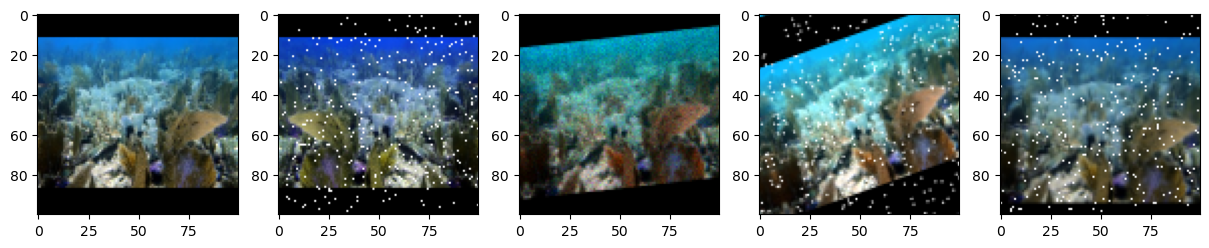

In [9]:
from matplotlib import pyplot as plt

#main

images = []
all_imgs, _ = load_all_jpg_images('./archive')
for img in all_imgs:
    images.append(resize(img))

"""
Ожидаемый результат - numpy массив images с изображениями из датасета, 
приведенными к единому размеру: 100х100x3 с сохранением соотношения сторон.
"""

images_count = len(images)
print(f"images in RAM {images_count}")

"""
Применение аугментации. Ожидаемый результат - 5 аугментированных изображений.
"""
colorTransformer = ColorTransformer()
geometricTransformer = GeometricTransformer()
noiseTransformer = NoiseTransformer()

transformation_pipeline_1 = [colorTransformer, noiseTransformer, geometricTransformer]
transformation_pipeline_2 = [geometricTransformer, colorTransformer, noiseTransformer]
transformation_pipeline_3 = [noiseTransformer, geometricTransformer, colorTransformer]
transformation_pipeline_4 = [colorTransformer, geometricTransformer, noiseTransformer]

target_img = images[np.random.randint(0, images_count-1)]

f, axes = plt.subplots(1, 5, figsize=(15, 5))
axes[0].imshow(target_img[..., ::-1])
augmented_image = apply_pipeline(target_img, transformation_pipeline_1)
axes[1].imshow(augmented_image[..., ::-1])
augmented_image = apply_pipeline(target_img, transformation_pipeline_2)
axes[2].imshow(augmented_image[..., ::-1])
augmented_image = apply_pipeline(target_img, transformation_pipeline_3)
axes[3].imshow(augmented_image[..., ::-1])
augmented_image = apply_pipeline(target_img, transformation_pipeline_4)
axes[4].imshow(augmented_image[..., ::-1])
plt.show()